In [1]:
# Bibliotecas base
import pandas as pd
import matplotlib.pyplot as plt

# Tratamento de dados
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Modelos para treinamento
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# Avaliacao de modelos
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Desativar warnings de depreciacao do XGBoost
import warnings
warnings.filterwarnings('ignore')


# Carregar o dataset

In [2]:
data = pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Tratamento dos dados
1. Selecao de colunas

In [3]:
# PassengerID, Name e Ticket sao categorias puramente nominais
# Cabin possui uma quantidade majoritaria de dados ausentes
data = data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


2. Tratar valores ausentes

In [4]:
# Substituir valores ausentes em 'Age' pela média das idades
data['Age'].fillna(data['Age'].mean(), inplace=True)

# Substituir valores ausentes em 'Embarked' pelo valor mais frequente
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

3. Codificar variáveis categóricas

In [5]:
# Usar LabelEncoder para 'Sex' (pois só tem duas categorias)
label_encoder = LabelEncoder()
data['Sex'] = label_encoder.fit_transform(data['Sex'])

# Usar OneHotEncoder para 'Embarked' (pois tem mais de duas categorias)
embarked_one_hot = pd.get_dummies(data['Embarked'], prefix='Embarked')
data = pd.concat([data, embarked_one_hot], axis=1)
data = data.drop(columns=['Embarked'])

# Converter colunas booleanas para inteiros
for col in ['Embarked_C', 'Embarked_Q', 'Embarked_S']:
    data[col] = data[col].astype(int)

data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,0,0,1
1,1,1,0,38.0,1,0,71.2833,1,0,0
2,1,3,0,26.0,0,0,7.9250,0,0,1
3,1,1,0,35.0,1,0,53.1000,0,0,1
4,0,3,1,35.0,0,0,8.0500,0,0,1


4. Dividir os dados em treino e teste

In [6]:
X = data.drop(columns=['Survived'])
y = data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
445,1,1,4.000000,0,2,81.8583,0,0,1
650,3,1,29.699118,0,0,7.8958,0,0,1
172,3,0,1.000000,1,1,11.1333,0,0,1
450,2,1,36.000000,1,2,27.7500,0,0,1
314,2,1,43.000000,1,1,26.2500,0,0,1


# Bagging

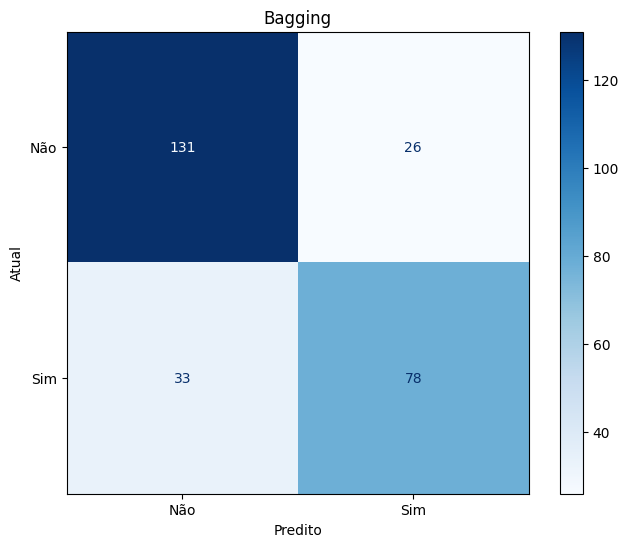

,precision,recall,f1-score,support
Não,0.80,0.83,0.82,157.00
Sim,0.75,0.70,0.73,111.00
accuracy,0.78,0.78,0.78,0.78
macro avg,0.77,0.77,0.77,268.00
weighted avg,0.78,0.78,0.78,268.00


In [7]:
# Treinar o modelo Bagging
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bagging_model.fit(X_train, y_train)

# Fazer previsões
bagging_predictions = bagging_model.predict(X_test)

# Avaliar o modelo
bagging_cm = confusion_matrix(y_test, bagging_predictions)
bagging_report = classification_report(y_test, bagging_predictions, output_dict=True, target_names=['Não', 'Sim'])

# Matriz de confusao
disp = ConfusionMatrixDisplay(confusion_matrix=bagging_cm, display_labels=['Não', 'Sim'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax)
ax.set_title('Bagging')
plt.xlabel('Predito')
plt.ylabel('Atual')
plt.show()

# Report
bagging_report = pd.DataFrame(bagging_report).transpose()
bagging_report.round(2)


# Boosting

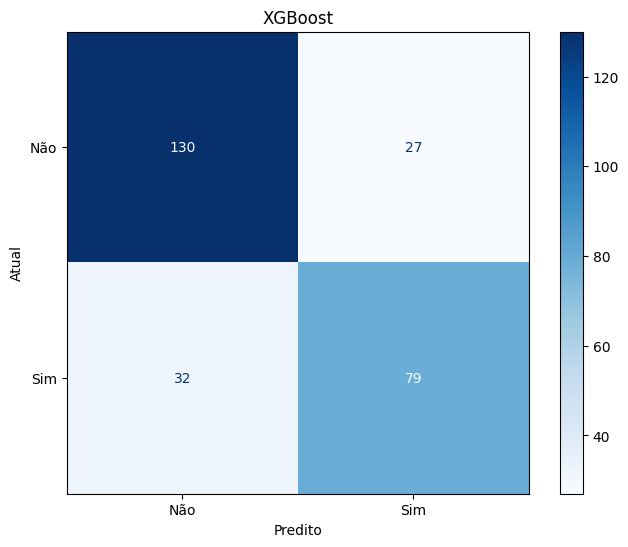

,precision,recall,f1-score,support
Não,0.80,0.83,0.82,157.00
Sim,0.75,0.71,0.73,111.00
accuracy,0.78,0.78,0.78,0.78
macro avg,0.77,0.77,0.77,268.00
weighted avg,0.78,0.78,0.78,268.00


In [8]:
# Treinar o modelo XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Fazer previsões
xgb_predictions = xgb_model.predict(X_test)

# Avaliar o modelo
xgb_cm = confusion_matrix(y_test, xgb_predictions)
xgb_report = classification_report(y_test, xgb_predictions, output_dict=True, target_names=['Não', 'Sim'])

# Matriz de confusao
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=['Não', 'Sim'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax)
ax.set_title('XGBoost')
plt.xlabel('Predito')
plt.ylabel('Atual')
plt.show()

# Report
xgb_report = pd.DataFrame(xgb_report).transpose()
xgb_report.round(2)

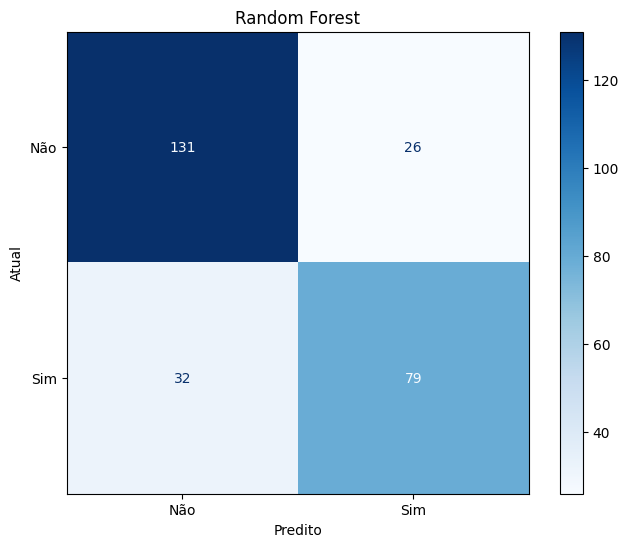

,precision,recall,f1-score,support
Não,0.80,0.83,0.82,157.00
Sim,0.75,0.71,0.73,111.00
accuracy,0.78,0.78,0.78,0.78
macro avg,0.78,0.77,0.78,268.00
weighted avg,0.78,0.78,0.78,268.00


In [9]:
# Treinar o modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Fazer previsões
rf_predictions = rf_model.predict(X_test)

# Avaliar o modelo
rf_cm = confusion_matrix(y_test, rf_predictions)
rf_report = classification_report(y_test, rf_predictions, output_dict=True, target_names=['Não', 'Sim'])

# Matriz de confusao
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=['Não', 'Sim'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax)
ax.set_title('Random Forest')
plt.xlabel('Predito')
plt.ylabel('Atual')
plt.show()

# Report
rf_report = pd.DataFrame(rf_report).transpose()
rf_report.round(2)